In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

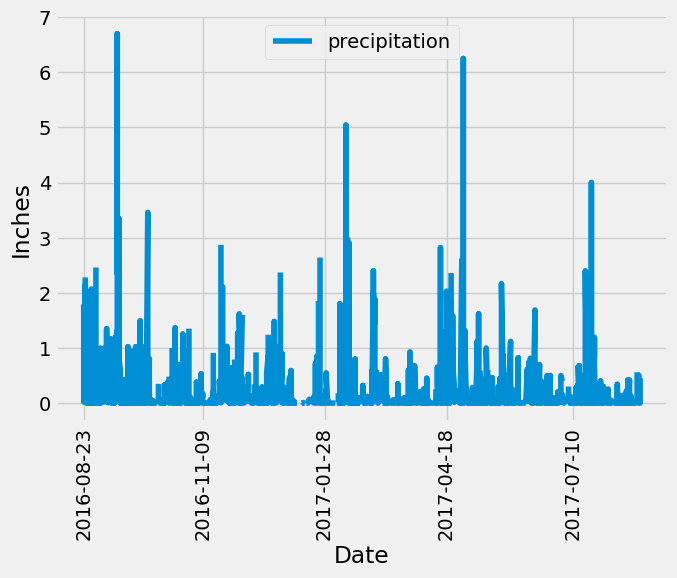

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_prior_date = most_recent_date - dt.timedelta(days=365)
one_year_prior_date_str = one_year_prior_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_prior_date_str).filter(Measurement.date <= most_recent_date_str).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prec_df = pd.DataFrame(year_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
prec_sorted_df = prec_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(7,6))
plt.plot(prec_sorted_df['date'],prec_sorted_df['precipitation'], label='precipitation')
plt.xticks(rotation=90)
xticks = prec_sorted_df['date'][::500]
plt.gca().set_xticks(xticks)
plt.xticks(xticks, rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

# Save the dataframe to a CSV file
prec_df.to_csv('outputs/precipitation_data.csv', index=False)

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
prec_summary = prec_sorted_df.describe()
prec_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).distinct().count()
total_stations

9

In [13]:
st = session.query(Station.station)
for s in st:
    print(f"{s.station}")

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0].station
only_most_active = session.query(Measurement).filter(Measurement.station == most_active_station)
only_most_active_list = []
for entry in only_most_active:
    if type(entry.tobs) == float:
        only_most_active_list.append(entry.tobs)
only_most_active_list_array = np.array(only_most_active_list)
characteristics = [(np.min(only_most_active_list_array), np.max(only_most_active_list_array), np.mean(only_most_active_list_array))]
print(characteristics)


[(54.0, 85.0, 71.66378066378067)]


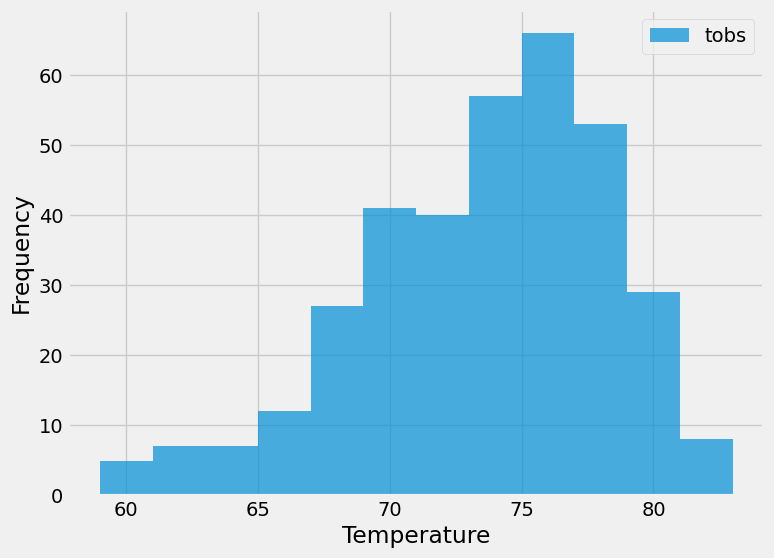

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_year_data = session.query(Measurement.tobs).filter(Measurement.date >= one_year_prior_date_str).filter(Measurement.date <= most_recent_date_str).filter(Measurement.station==most_active_station).all()
temperatures = [tobs for (tobs,) in active_year_data]
plt.figure(figsize=(8,6))
plt.hist(temperatures, bins=12, alpha=0.7, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

In [17]:
mas_year = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year_prior_date_str).filter(Measurement.date <= most_recent_date_str).filter(Measurement.station==most_active_station).all()
mas_year_df = pd.DataFrame(mas_year, columns=['date', 'temperature observed'])
# Save the dataframe to a CSV file
mas_year_df.to_csv('outputs/temp_obs.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'outputs/temp_obs.csv'

# Close Session

In [ ]:
# Close Session
session.close()